# Day 20 - Outdoors

Sources
- Dogs per district from [xx]()
- UK postcode districts polygons via [xx]()

## Setup

In [1]:
import os
import configparser

import pandas as pd
import numpy as np
import requests
import geopandas as gpd
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.lines import Line2D

In [2]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
config_file =  os.path.join(root, 'config.cfg')

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config['geodata']['path']

# set custom font
plt.rcParams['font.family'] = ['FreeSans']
from matplotlib import font_manager
title_font = font_manager.FontProperties(fname='C:\\Windows\\Fonts\\Dog Rough.otf')

## Load data

In [3]:
# Postcode district shapefiles
gdf = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, 'uk-postcodes\\UKPostcodeDistricts_polygons.geojson'))
gdf = gdf.rename(columns={'Name': 'PostcodeDistrict'}).to_crs('32630')

# dogs per district
df = pd.read_csv('APHA0381-Dogs_Per_HouseholdDJ.csv')

In [15]:
# merge
merged = pd.merge(gdf, df, on='PostcodeDistrict', how='left')

# exclude Stockley Park (not sure there are any households in the area)
merged.loc[merged['PostcodeDistrict']=='UB11', 'DogsPerHousehold'] = 0

# bucket counts
merged['Dogs_bucketed'] = [1 if i <1 else 2 for i in merged['DogsPerHousehold']]

# get centroids
centroids = merged.sort_values(by='DogsPerHousehold', ascending=False)[['PostcodeDistrict', 'DogsPerHousehold', 'geometry']]
centroids['geometry'] = centroids['geometry'].centroid

# bin Dogs
centroids['DogsPerHousehold_binned'] = 1
centroids.loc[centroids['DogsPerHousehold']>2, 'DogsPerHousehold_binned'] = 2
centroids.loc[centroids['DogsPerHousehold']>3, 'DogsPerHousehold_binned'] = 3
centroids.loc[centroids['DogsPerHousehold']>4, 'DogsPerHousehold_binned'] = 4

centroids['size'] = centroids['DogsPerHousehold_binned'] *20


## Visualise

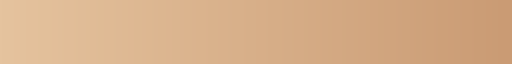

In [4]:
colors_for_map = ['#E5C39E', '#CA9B74']
cmap = colors.LinearSegmentedColormap.from_list('cmap_dogs',[colors.hex2color(c) for c in  colors_for_map])
cmap

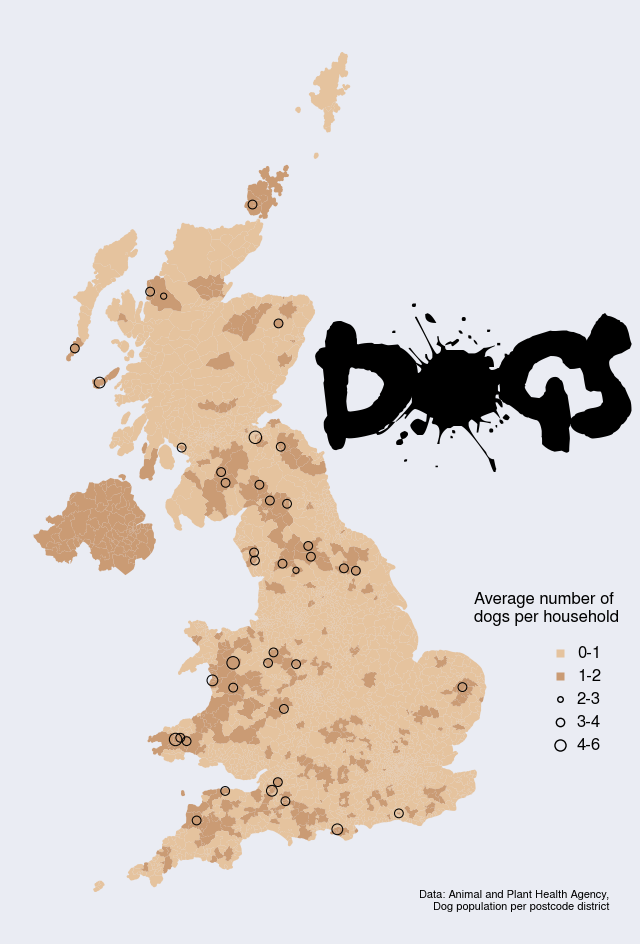

In [18]:
fig, ax = plt.subplots(figsize=(8,12))

clrs= {'dot':'#9e8f0f', 'bg': '#Eaecf3'}

# plot data
merged.plot(column='Dogs_bucketed', ax=ax, cmap=cmap)
centroids.head(40).plot(ax=ax, facecolor='None',edgecolor='black', markersize='size', linewidth=0.75)
fig.set_facecolor(clrs['bg'])
ax.axis('off')

# === 
# Legend
lgd = fig.add_axes([0.84, 0.24, 0.13, 0.13]) 
legend_elements2 = [Line2D([0], [0], marker='s', markeredgecolor='None',markersize=6, color='#E5C39E', linewidth=0, label='0-1'),
                    Line2D([0], [0], marker='s', markeredgecolor='None',markersize=6, color='#CA9B74', linewidth=0, label='1-2'),
                    Line2D([0], [0], marker='o', markeredgecolor='black',markersize=4, color='None', linewidth=0, label='2-3'), 
                  Line2D([0], [0], marker='o', markeredgecolor='black', markersize=6, color='None',linewidth=0, label='3-4'),
                  Line2D([0], [0], marker='o', markeredgecolor='black', markersize=8, color='None',linewidth=0, label='4-6')]
L = lgd.legend(frameon=False, handles=legend_elements2, loc='center', ncol=1, handletextpad=0.2,labelspacing=0.5)
plt.setp(L.texts,  va='baseline', size=12, )    
lgd.axis('off')

# === 
# title + footer
plt.figtext(0.59, 0.52 , 'DOGS', fontsize=125, fontweight='bold', ha='left', color='black',
            fontproperties=title_font)
plt.figtext(0.78, 0.37 , 'Average number of\ndogs per household', fontsize=12,
             fontweight='regular', ha='left', color='black', linespacing=1.2)
plt.figtext(0.95, 0.13 , 'Data: Animal and Plant Health Agency,\nDog population per postcode district',
             fontsize=8,  fontweight='regular', ha='right',  color='black')

plt.savefig('dog-population-uk-v1.png', facecolor=clrs['bg'], dpi=120, bbox_inches='tight',pad_inches=0.45)
#plt.savefig('dog-population-uk-v1.svg', transparent=True)

plt.show()

## Playground

In [7]:
#join polygons for outline
merged_outline = gpd.GeoDataFrame({'geometry': merged.unary_union,'index':[0]}, crs=merged.crs)